## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

time: 11.4 ms


In [3]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

time: 12.3 ms


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


time: 2.15 s


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

time: 32.1 ms


In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

time: 2.2 s


In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

time: 105 ms


In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
time: 32.2 ms


In [9]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

time: 537 ms


In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9232
Unique tokens in target (en) vocabulary: 6662
time: 27.6 ms


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'года',
 'plus',
 'настольного',
 'часть',
 'хьюстон',
 'magic',
 'тяньхэ',
 'древними',
 'торони']

time: 34.1 ms


And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>',
 '37',
 'fashion',
 'clérigos',
 'lithuanian',
 'shijiazhuang',
 'monahans']

time: 32.3 ms


And here is example from train dataset:

In [13]:
print(vars(train_data.examples[9]))

{'trg': ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'a', 'tour', 'desk', ',', 'luggage', 'storage', 'and', 'a', 'vending', 'machine', '.'], 'src': ['в', 'числе', 'удобств', 'отеля', 'автомат', 'по', 'продаже', 'напитков', 'и', 'закусок', ',', 'камера', 'хранения', 'багажа', 'и', 'экскурсионное', 'бюро', '.']}
time: 30.9 ms


Let's check the length distributions:

Length distribution in Train data


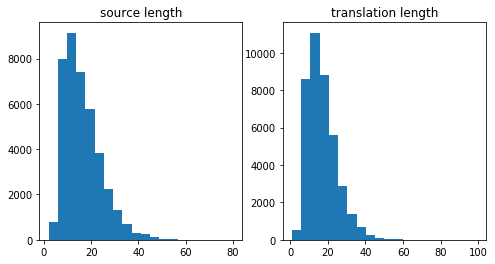

time: 518 ms


In [14]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


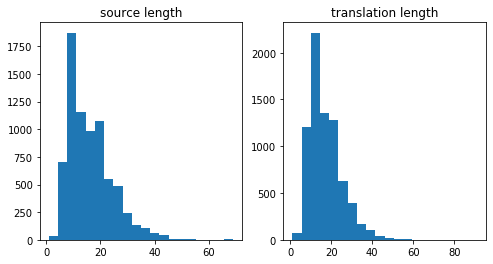

time: 408 ms


In [15]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

time: 33.5 ms


In [17]:
device

device(type='cpu')

time: 32.2 ms


In [18]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

time: 31.5 ms


In [19]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.LongTensor of size 43x128]
	[.src]:[torch.LongTensor of size 43x128]
torch.Size([43, 128]) torch.Size([43, 128])
time: 128 ms


In [20]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

time: 28.1 ms


In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

time: 148 ms


In [22]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9232, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6662, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6662, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

time: 250 ms


In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,842,886 trainable parameters
time: 32 ms


In [24]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

time: 30.8 ms


In [107]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, scheduler=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in tqdm(enumerate(iterator)):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        if scheduler is not None:
            scheduler.step(loss)
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
            print(f"lr: {optimizer.state_dict()['param_groups'][0]['lr']:.7f}")

        
    return epoch_loss / len(iterator)

time: 35.2 ms


In [83]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in tqdm(enumerate(iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

time: 32.5 ms


In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

time: 31.1 ms


In [28]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

time: 30.7 ms


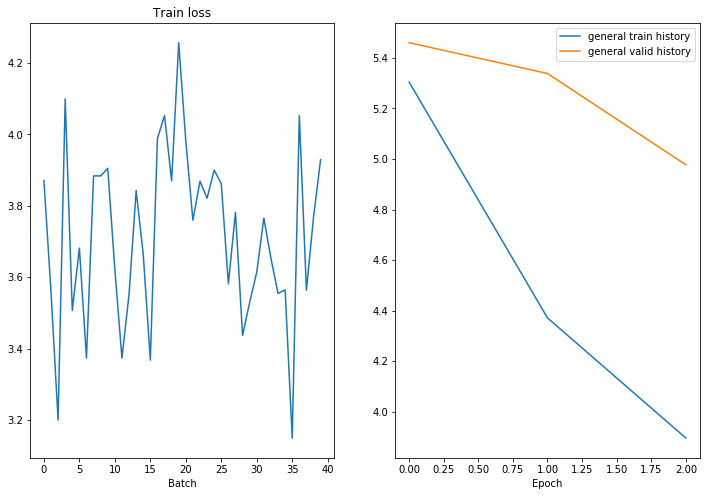

KeyboardInterrupt: 

time: 2h 37min 3s


In [29]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [30]:
del utils

NameError: name 'utils' is not defined

time: 42.4 ms


In [31]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

time: 38.5 ms


In [32]:
batch = next(iter(test_iterator))

time: 40.9 ms


In [33]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: a a a a kitchen .

Original: free parking is offered .
Generated: free parking .

time: 153 ms


In [34]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

time: 33.1 ms


In [92]:
from tqdm import tqdm

time: 31.2 ms


In [36]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:28,  2.10it/s]

time: 28.1 s


In [37]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

6.534729752964598

time: 894 ms


# Добавим attention

In [84]:
import my_network_with_attention
Encoder = my_network_with_attention.Encoder
Decoder = my_network_with_attention.Decoder
Seq2Seq = my_network_with_attention.Seq2Seq

time: 31.3 ms


In [85]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.0
LR = 10e-4

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec).to(device)

time: 184 ms


In [86]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

time: 31.8 ms


In [87]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(9232, 256)
    (gru): GRU(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embed): Embedding(6662, 256)
    (dropout): Dropout(p=0.0, inplace=True)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (gru): GRU(768, 512, num_layers=2)
    (out): Linear(in_features=1024, out_features=6662, bias=True)
  )
)

time: 350 ms


In [88]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,057,990 trainable parameters
time: 32.1 ms


In [89]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.NLLLoss(ignore_index=PAD_IDX)

time: 32.1 ms


In [90]:
train_history = []
valid_history = []

N_EPOCHS = 100
CLIP = 10

best_valid_loss = float('inf')

time: 31.5 ms


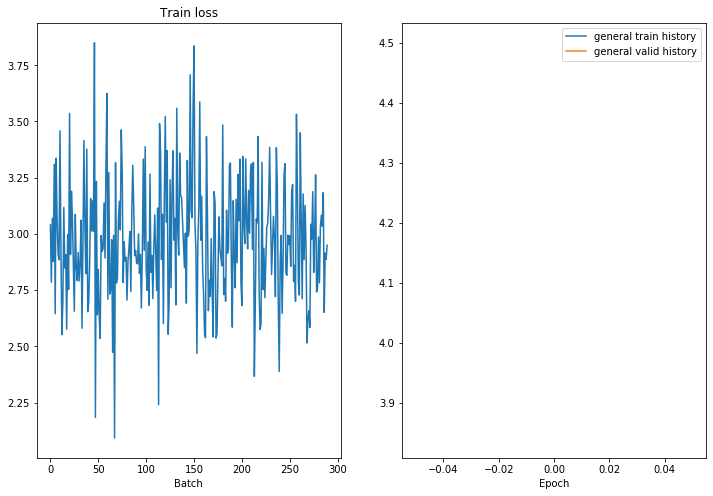


290it [24:25,  4.91s/it]
291it [24:30,  4.78s/it]
292it [24:35,  5.06s/it]
293it [24:40,  5.04s/it]
294it [24:45,  4.94s/it]
295it [24:50,  5.01s/it]
296it [24:55,  4.97s/it]
297it [24:59,  4.75s/it]
298it [25:04,  4.60s/it]
299it [25:08,  4.43s/it]

KeyboardInterrupt: 

time: 2h 10min 11s


In [93]:
for epoch in tqdm(range(N_EPOCHS)):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn_tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [95]:
train_loss, valid_loss

(3.841428953742981, 4.500245112407057)

time: 31.9 ms


__Let's take a look at our network quality__:

In [96]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

time: 32.7 ms


In [97]:
batch = next(iter(test_iterator))

time: 38.6 ms


In [98]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the property offers free parking .
Generated: the property offers free parking .

Original: the property offers free parking .
Generated: the property offers free parking .

time: 131 ms


In [99]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

time: 31.3 ms


In [100]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)



0it [00:00, ?it/s]

1it [00:00,  5.68it/s]

2it [00:00,  5.24it/s]

3it [00:00,  5.66it/s]

4it [00:00,  5.09it/s]

5it [00:00,  5.26it/s]

6it [00:01,  5.35it/s]

7it [00:01,  5.49it/s]

8it [00:01,  5.27it/s]

9it [00:01,  5.44it/s]

10it [00:01,  5.34it/s]

11it [00:02,  5.46it/s]

12it [00:02,  5.72it/s]

13it [00:02,  5.79it/s]

14it [00:02,  5.65it/s]

15it [00:02,  5.25it/s]

16it [00:02,  5.39it/s]

17it [00:03,  5.31it/s]

18it [00:03,  4.91it/s]

19it [00:03,  5.00it/s]

20it [00:03,  4.70it/s]

21it [00:04,  4.76it/s]

22it [00:04,  4.80it/s]

23it [00:04,  4.93it/s]

24it [00:04,  5.06it/s]

25it [00:04,  4.67it/s]

26it [00:05,  4.74it/s]

27it [00:05,  4.68it/s]

28it [00:05,  4.51it/s]

29it [00:05,  4.46it/s]

30it [00:05,  4.67it/s]

31it [00:06,  4.62it/s]

32it [00:06,  4.60it/s]

33it [00:06,  4.51it/s]

34it [00:06,  4.59it/s]

35it [00:07,  4.74it/s]

36it [00:07,  5.02it/s]

37it [00:07,  5.27it/s]

38it [00:07,  5.07it/s]

39it [00:07,  4.77it/s]

40it [00:08,

time: 1min 16s


In [101]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

19.08612970738998

time: 1.11 s


# Добавим ReduceLROnPlateau

In [102]:
import my_network_with_attention
Encoder = my_network_with_attention.Encoder
Decoder = my_network_with_attention.Decoder
Seq2Seq = my_network_with_attention.Seq2Seq

time: 470 ms


In [103]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.0
LR = 10e-4

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec).to(device)

time: 187 ms


In [104]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

time: 31.2 ms


In [105]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(9232, 256)
    (gru): GRU(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embed): Embedding(6662, 256)
    (dropout): Dropout(p=0.0, inplace=True)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (gru): GRU(768, 512, num_layers=2)
    (out): Linear(in_features=1024, out_features=6662, bias=True)
  )
)

time: 355 ms


In [106]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,057,990 trainable parameters
time: 31.7 ms


In [108]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.NLLLoss(ignore_index=PAD_IDX)

time: 31.9 ms


In [109]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    factor=0.6, patience=150,
    min_lr=5e-6,
)

time: 31 ms


In [110]:
train_history = []
valid_history = []

N_EPOCHS = 100
CLIP = 10

best_valid_loss = float('inf')

time: 32.1 ms


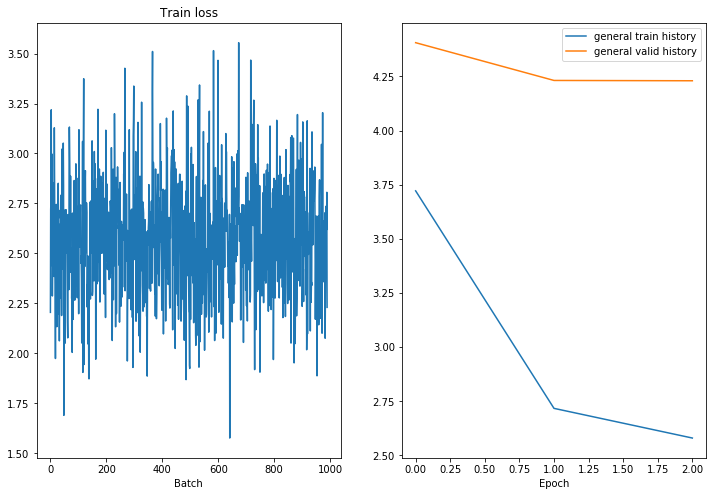




990it [1:17:06,  4.97s/it]

lr: 0.0000050





991it [1:17:12,  5.49s/it]

KeyboardInterrupt: 

time: 5h 59min 56s


In [111]:
for epoch in tqdm(range(N_EPOCHS)):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, scheduler=scheduler)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn_tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [112]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

time: 52.8 ms


In [113]:
batch = next(iter(test_iterator))

time: 38.6 ms


In [114]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the property offers free parking .
Generated: the property offers free parking .

Original: the property offers free parking .
Generated: the property offers free parking .

time: 122 ms


In [119]:
for idx in [5,6]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: house is just over 30 miles from , home to an 18th - century which is now a visitor attraction , and the impressive castle . home to the scottish sanctuary , is a 35 - minute drive from , and the point for ferry trips to the isle of .
Generated: offering a views of the , b & b is set in , 2 km from , , is a minutes ’ drive from .

Original: the property is a 10 - minute walk from road and square , a 2 - minute drive from li or international square and a 10 - minute drive from alley . it is a 20 - minute drive from memorial temple or chengdu north railway station and a 30 - minute drive from shuangliu international airport .
Generated: the and square and a 10 - minute walk from and and and are a 2 - minute drive away , and the and railway station is a 20 - minute drive away .

time: 791 ms


In [115]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

time: 32 ms


In [116]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)





0it [00:00, ?it/s]



1it [00:00,  6.32it/s]



2it [00:00,  5.78it/s]



3it [00:00,  5.99it/s]



4it [00:00,  5.28it/s]



5it [00:00,  5.44it/s]



6it [00:01,  5.46it/s]



7it [00:01,  5.59it/s]



8it [00:01,  5.29it/s]



9it [00:01,  5.44it/s]



10it [00:01,  5.33it/s]



11it [00:02,  5.44it/s]



12it [00:02,  5.71it/s]



13it [00:02,  5.78it/s]



14it [00:02,  5.47it/s]



15it [00:02,  4.89it/s]



16it [00:03,  4.95it/s]



17it [00:03,  4.81it/s]



18it [00:03,  4.81it/s]



19it [00:03,  5.08it/s]



20it [00:03,  5.03it/s]



21it [00:04,  5.03it/s]



22it [00:04,  5.13it/s]



23it [00:04,  5.21it/s]



24it [00:04,  5.29it/s]



25it [00:04,  4.73it/s]



26it [00:05,  4.85it/s]



27it [00:05,  5.16it/s]



28it [00:05,  4.98it/s]



29it [00:05,  5.06it/s]



30it [00:05,  5.27it/s]



31it [00:05,  5.38it/s]



32it [00:06,  5.40it/s]



33it [00:06,  5.18it/s]



34it [00:06,  5.00it/s]



35it [00:06,  4.96it/s]



36it [00:06,  5.15it/s]



37it [00:07

207it [01:02,  2.03it/s]



208it [01:03,  1.91it/s]



209it [01:03,  1.91it/s]



210it [01:04,  1.88it/s]



211it [01:04,  1.93it/s]



212it [01:05,  1.99it/s]



213it [01:05,  1.83it/s]



214it [01:06,  1.68it/s]



215it [01:07,  1.70it/s]



216it [01:07,  1.72it/s]



217it [01:08,  1.71it/s]



218it [01:08,  1.72it/s]



219it [01:09,  1.61it/s]



220it [01:10,  1.64it/s]



221it [01:10,  1.55it/s]



222it [01:11,  1.59it/s]



223it [01:12,  1.62it/s]



224it [01:12,  1.62it/s]



225it [01:13,  1.53it/s]



226it [01:14,  1.49it/s]



227it [01:14,  1.52it/s]



228it [01:15,  1.47it/s]



229it [01:16,  1.35it/s]



230it [01:17,  1.35it/s]



231it [01:18,  1.13it/s]



232it [01:19,  1.17it/s]



233it [01:20,  1.06it/s]



234it [01:21,  1.01s/it]



235it [01:22,  2.85it/s]

time: 1min 22s


In [117]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

26.24536013661181

time: 1.26 s


# Добавим BPE

Т.к. есть заметное переобучение, то надо уменьшить число параметров. Больше всего параметров получается из-за линейных слоев и эмбеддингов. То есть если уменьшим размеры словарей, что число параметров значительно уменьшится => меньше переобучения => лучше обощающая способность модели.

BPE в свою очередь позволяет уменьшить размер словаря при этом не потеряв в покрытии всего словарного запаса: просто будем хранить в словаре не только слова целиком, но и буквенные ngramm'ы.

Для эксперимента уменьшим размеры словарей в 2 раза.

In [124]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

time: 33.3 ms


In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

time: 32.1 ms


In [141]:
# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open(path_do_data):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(' '.join(tokenize(src_line)) + '\n')
        f_dst.write(' '.join(tokenize(dst_line)) + '\n')

# build and apply bpe vocs
bpe = {}
num_symbols_lang = {
    'en': 6662//2,
    'ru': 9232//2,
}
for lang in ['en', 'ru']:
    learn_bpe(
        open('./train.' + lang), 
        open('bpe_rules.' + lang, 'w'), 
        num_symbols=num_symbols_lang[lang],
        min_frequency=3,
    )
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

time: 19.1 s


In [125]:
!head ../../datasets/Machine_translation_EN_RU/data.txt

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.
At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.	В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.
Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.	Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.
Each has a TV and a private bathroom with shower.	В вашем распоряжении также телевизор и собственная ванная комната с душем.
Your room comes with air conditioning and satellite TV.	Номер оснащен кондиционером и спутниковым телевидением.
They are styled in cream-coloured hues and some of them feature private balconies with seating areas.	Они оформлены в кремовых тонах, в некоторых из них имеются отдельные б

In [132]:
!wc -l ../../datasets/Machine_translation_EN_RU/data.txt

   50000 ../../datasets/Machine_translation_EN_RU/data.txt
time: 174 ms


In [142]:
# union in one file
with open('train.bpe.en', 'r') as f_src, open('train.bpe.ru', 'r') as f_dst, open('bpe_data.txt', 'w') as f_data:
    for line_src, line_dst in zip(f_src, f_dst):
        f_data.write('\t'.join([line_src.strip(), line_dst.strip()]) + '\n')

time: 204 ms


In [143]:
!head bpe_data.txt

cor@@ del@@ ia hotel is situated in tbilisi , a 3 - minute walk away from saint tr@@ in@@ ity church .	отель cor@@ del@@ ia расположен в тбилиси , в 3 минутах ходьбы от свя@@ то - тро@@ и@@ ц@@ кого собора .
at tu@@ pi@@ r@@ mar@@ ka lodge you will find a 24 - hour front desk , room service , and a snack bar .	в числе удобств лод@@ жа tu@@ p@@ ir@@ mar@@ ka круглосуточная стойка регистрации и снэк - бар . гости могут воспользоваться услу@@ гой доставки еды и напитков в номер .
featuring free wifi in all areas , n@@ ai@@ g@@ ao xi@@ ao@@ w@@ o offers accommodation in shanghai .	апартаменты na@@ i@@ ga@@ o xi@@ a@@ ow@@ o расположены в городе шан@@ ха@@ й . к услугам гостей бесплатный wi - fi во всех зонах .
each has a tv and a private bathroom with shower .	в вашем распоряжении также телевизор и собственная ванная комната с душем .
your room comes with air conditioning and satellite tv .	номер оснащен кондиционером и спутниковым телевидением .
they are styled in cre@@ am - colo@@ u@@ re

In [144]:
!wc -l bpe_data.txt

   50000 bpe_data.txt
time: 175 ms


In [145]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='bpe_data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

time: 3.35 s


In [146]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

time: 223 ms


In [147]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
time: 31.1 ms


In [148]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

time: 486 ms


In [149]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 4182
Unique tokens in target (en) vocabulary: 2938
time: 31.4 ms


Here are tokens from original (RU) corpus:

In [150]:
SRC.vocab.itos[::1000]

['<unk>', 'спорта', 'мот', 'fre', 'оби']

time: 31.3 ms


And from target (EN) corpus:

In [151]:
TRG.vocab.itos[::1000]

['<unk>', 'menu', 'nes']

time: 28.2 ms


And here is example from train dataset:

In [152]:
print(vars(train_data.examples[9]))

{'trg': ['a', 'bar', 'is', 'located', 'at', 'the', 'hotel', '.'], 'src': ['гости', 'могут', 'воспользоваться', 'услугами', 'бизнес', '-', 'центра', 'и', 'заказать', 'различные', 'напитки', 'в', 'баре', '.']}
time: 27 ms


Let's check the length distributions:

Length distribution in Train data


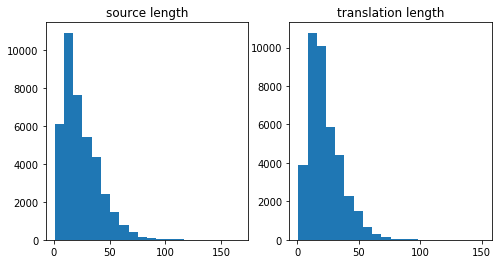

time: 501 ms


In [153]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


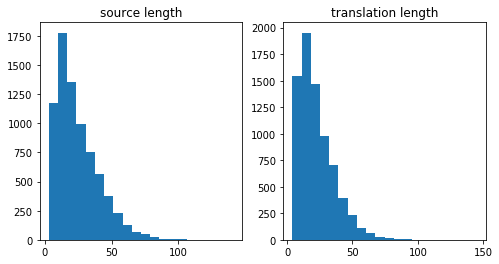

time: 431 ms


In [154]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [155]:
import my_network_with_attention
Encoder = my_network_with_attention.Encoder
Decoder = my_network_with_attention.Decoder
Seq2Seq = my_network_with_attention.Seq2Seq

time: 31.2 ms


In [156]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.0
LR = 10e-4

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec).to(device)

time: 192 ms


In [157]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

time: 41.6 ms


In [158]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(4182, 256)
    (gru): GRU(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embed): Embedding(2938, 256)
    (dropout): Dropout(p=0.0, inplace=True)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (gru): GRU(768, 512, num_layers=2)
    (out): Linear(in_features=1024, out_features=2938, bias=True)
  )
)

time: 286 ms


In [159]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,994,746 trainable parameters
time: 33.6 ms


In [160]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.NLLLoss(ignore_index=PAD_IDX)

time: 32.2 ms


In [161]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    factor=0.6, patience=150,
    min_lr=5e-6,
)

time: 36.6 ms


In [162]:
train_history = []
valid_history = []

N_EPOCHS = 100
CLIP = 10

best_valid_loss = float('inf')

time: 30.8 ms


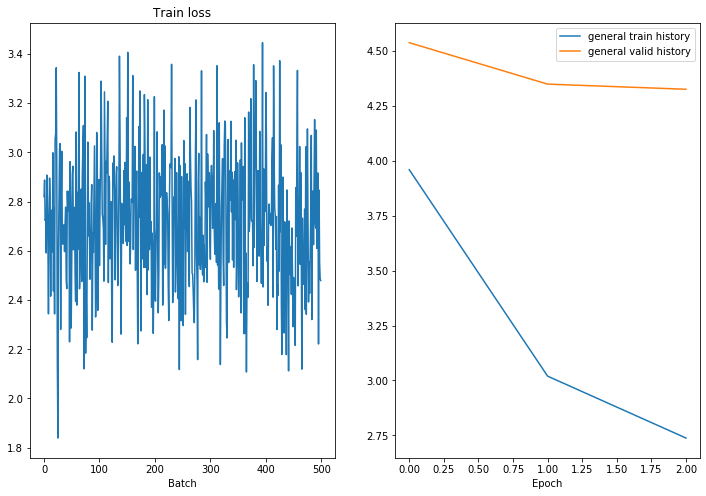






500it [53:15,  6.02s/it]

lr: 0.0000050







501it [53:20,  5.79s/it]




502it [53:31,  7.19s/it]




503it [53:39,  7.50s/it]




504it [53:46,  7.43s/it]

KeyboardInterrupt: 

time: 7h 39min 20s


In [163]:
for epoch in tqdm(range(N_EPOCHS)):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, scheduler=scheduler)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn_tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [164]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

time: 51.4 ms


In [165]:
batch = next(iter(test_iterator))

time: 65.1 ms


In [166]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is also an electric kettle .
Generated: you will find an electric kettle in the room .

Original: the property offers free parking .
Generated: the property offers free parking .

time: 102 ms


In [167]:
for idx in [5,6]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: towels are featured .
Generated: towels are available .

Original: there is also a kitchen , equipped with an oven .
Generated: the kitchen is equipped with an oven .

time: 103 ms


In [168]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

time: 30.5 ms


In [169]:
from typing import List

def bpe2tokens(bpe_tokens: List[str]) -> List[str]:
    if len(bpe_tokens) == 0:
        return []
    
    tokens = [bpe_tokens[0]]
    for bpe_token in bpe_tokens[1:]:
        if bpe_token.startswith('@@'):
            tokens[-1] = tokens[-1] + bpe_token[2:]
        else:
            tokens.append(bpe_token)
            
    return tokens

time: 31.5 ms


In [170]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([bpe2tokens(get_text(x, TRG.vocab)) for x in trg.cpu().numpy().T])
        generated_text.extend([bpe2tokens(get_text(x, TRG.vocab)) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)







0it [00:00, ?it/s]





1it [00:00,  9.21it/s]





2it [00:00,  8.02it/s]





3it [00:00,  7.62it/s]





4it [00:00,  7.81it/s]





5it [00:00,  7.72it/s]





6it [00:00,  7.80it/s]





7it [00:00,  8.11it/s]





8it [00:01,  7.89it/s]





9it [00:01,  7.89it/s]





10it [00:01,  8.08it/s]





11it [00:01,  7.14it/s]





12it [00:01,  7.48it/s]





13it [00:01,  7.54it/s]





14it [00:01,  6.67it/s]





15it [00:02,  6.76it/s]





16it [00:02,  7.25it/s]





17it [00:02,  6.57it/s]





18it [00:02,  7.01it/s]





19it [00:02,  6.51it/s]





20it [00:02,  5.31it/s]





21it [00:03,  5.37it/s]





22it [00:03,  5.19it/s]





23it [00:03,  5.39it/s]





24it [00:03,  5.22it/s]





25it [00:03,  5.54it/s]





26it [00:04,  5.50it/s]





27it [00:04,  5.70it/s]





28it [00:04,  5.87it/s]





29it [00:04,  5.89it/s]





30it [00:04,  5.82it/s]





31it [00:04,  5.14it/s]





32it [00:05,  4.92it/s]





33it [00:05,  5.30it/s]





34it [00:05,  5.63it/s

173it [00:52,  1.97it/s]





174it [00:52,  1.81it/s]





175it [00:53,  1.74it/s]





176it [00:53,  1.80it/s]





177it [00:54,  1.81it/s]





178it [00:55,  1.70it/s]





179it [00:55,  1.67it/s]





180it [00:56,  1.75it/s]





181it [00:56,  1.79it/s]





182it [00:57,  1.81it/s]





183it [00:57,  1.77it/s]





184it [00:58,  1.82it/s]





185it [00:59,  1.70it/s]





186it [00:59,  1.76it/s]





187it [01:00,  1.70it/s]





188it [01:00,  1.62it/s]





189it [01:01,  1.68it/s]





190it [01:02,  1.64it/s]





191it [01:02,  1.56it/s]





192it [01:03,  1.51it/s]





193it [01:04,  1.49it/s]





194it [01:04,  1.54it/s]





195it [01:05,  1.57it/s]





196it [01:06,  1.53it/s]





197it [01:06,  1.58it/s]





198it [01:07,  1.57it/s]





199it [01:08,  1.51it/s]





200it [01:08,  1.52it/s]





201it [01:09,  1.42it/s]





202it [01:10,  1.37it/s]





203it [01:11,  1.36it/s]





204it [01:11,  1.31it/s]





205it [01:12,  1.35it/s]





206it [01:

time: 1min 46s


In [173]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

20.122053990107673

time: 926 ms


# Выводы

Лучший результат показала комбинация attention и lr scheduler(26 bleu).

Как говорится, Attention Is All You Need)

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points